## Q学習で配管ルーティング設計
### modification todo
- OK : ゲームを変更する(行けないステートを作る＋何通りのS→Gを作る)
- OK : ゲームサイズを大きくする 5x5 → 10x10
- 報酬系の修正
    - time outを儲ける 0点
    - 戻ると終了 -1 x (timeout - time_終了)
- DQNに修正

In [176]:
# 使用するパッケージの宣言
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [208]:
# ゲームの設定
## ゲームサイズ size x size
size = 5

## 配線できない場所の設定
collision_state = [6, 13, 16]

## 学習回数
stop_episode = 100

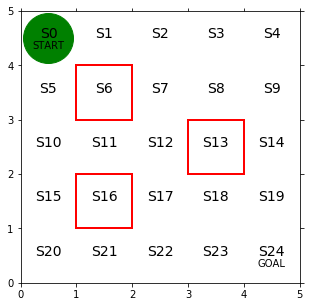

In [207]:
# 初期位置での迷路の様子

# 図を描く大きさと、図の変数名を宣言
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

# 赤い壁を描く
for i in collision_state:
    s_row = int(i/size)
    s_col = i%size
    plt.plot([s_col, s_col], [size-s_row-1, size-s_row], color='red', linewidth=2)
    plt.plot([s_col, s_col+1], [size-s_row, size-s_row], color='red', linewidth=2)
    plt.plot([s_col+1, s_col+1], [size-s_row, size-s_row-1], color='red', linewidth=2)
    plt.plot([s_col+1, s_col], [size-s_row-1, size-s_row-1], color='red', linewidth=2)

# 状態を示す文字S0～S**を描く
count = 0
for i in range(size):
    for j in range(size):
        plt.text((j+0.5),(size-i-0.5),'S{}'.format(str(count)), size=14, ha='center')
        count = count + 1

# start-goal
plt.text(0.5, (size-0.7), 'START', ha='center')
plt.text((size-0.5), 0.3, 'GOAL', ha='center')

# 描画範囲の設定と目盛りを消す設定
ax.set_xlim(0, size)
ax.set_ylim(0, size)
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='off', right='off', left='off', labelleft='off')

# 現在地S0に緑丸を描画する
line, = ax.plot([0.5], [size-0.5], marker="o", color='g', markersize=50)


In [197]:
theta_0 = np.zeros(4)
for i in range(size*size-1):
    s_row = int(i/size)
    s_col = i%size
    state_array = np.ones(4)
    
    # 壁のステート
    if(collision_state.count(i)==1):
        state_array[:] = np.nan
    else:
        # 端の壁衝突
        if(s_row == 0):#上
            state_array[0] = np.nan
        if(s_col == (size-1)):#右
            state_array[1] = np.nan
        if(s_row == (size-1)):#下
            state_array[2] = np.nan
        if(s_col == 0):#左
            state_array[3] = np.nan
        # 設定した壁衝突
        for j in collision_state:
            cs_row = int(j/size)
            cs_col = j%size
            #上
            if((cs_row == (s_row-1)) and (cs_col==s_col)):
                state_array[0] = np.nan
            #右
            if((cs_row == s_row) and (cs_col==(s_col+1))):
                state_array[1] = np.nan
            #下
            if((cs_row == (s_row+1)) and (cs_col==s_col)):
                state_array[2] = np.nan
            #左
            if((cs_row == s_row) and (cs_col==(s_col-1))):
                state_array[3] = np.nan
    # 結合
    if(i == 0):
        theta_0 = state_array
    else:
        theta_0 = np.vstack((theta_0,state_array))
theta_0

array([[nan,  1.,  1., nan],
       [nan,  1., nan,  1.],
       [nan,  1.,  1.,  1.],
       [nan,  1.,  1.,  1.],
       [nan, nan,  1.,  1.],
       [ 1., nan,  1., nan],
       [nan, nan, nan, nan],
       [ 1.,  1.,  1., nan],
       [ 1.,  1., nan,  1.],
       [ 1., nan,  1.,  1.],
       [ 1.,  1.,  1., nan],
       [nan,  1., nan,  1.],
       [ 1., nan,  1.,  1.],
       [nan, nan, nan, nan],
       [ 1., nan,  1., nan],
       [ 1., nan,  1., nan],
       [nan, nan, nan, nan],
       [ 1.,  1.,  1., nan],
       [nan,  1.,  1.,  1.],
       [ 1., nan,  1.,  1.],
       [ 1.,  1., nan, nan],
       [nan,  1., nan,  1.],
       [ 1.,  1., nan,  1.],
       [ 1.,  1., nan,  1.]])

In [198]:
# 方策パラメータtheta_0をランダム方策piに変換する関数の定義


def simple_convert_into_pi_from_theta(theta):
    '''単純に割合を計算する'''

    [m, n] = theta.shape  # thetaの行列サイズを取得
    pi = np.zeros((m, n))
    for i in range(0, m):
        pi[i, :] = theta[i, :] / np.nansum(theta[i, :])  # 割合の計算

    pi = np.nan_to_num(pi)  # nanを0に変換

    return pi

# ランダム行動方策pi_0を求める
pi_0 = simple_convert_into_pi_from_theta(theta_0)


In [199]:
# 初期の行動価値関数Qを設定

[a, b] = theta_0.shape  # 行と列の数をa, bに格納
Q = np.random.rand(a, b) * theta_0 * 0.1
# *theta0をすることで要素ごとに掛け算をし、Qの壁方向の値がnanになる
print("a={}, b={}".format(a,b))
Q

a=24, b=4


array([[       nan, 0.00705855, 0.05600027,        nan],
       [       nan, 0.08235423,        nan, 0.06229729],
       [       nan, 0.00965898, 0.00916647, 0.0241497 ],
       [       nan, 0.05186882, 0.08078635, 0.06686276],
       [       nan,        nan, 0.02098536, 0.08392918],
       [0.05354948,        nan, 0.06911597,        nan],
       [       nan,        nan,        nan,        nan],
       [0.05524151, 0.09924333, 0.08465994,        nan],
       [0.08324195, 0.06608257,        nan, 0.07506119],
       [0.08463929,        nan, 0.07714646, 0.00229132],
       [0.08199802, 0.08861721, 0.09281774,        nan],
       [       nan, 0.00835061,        nan, 0.06677623],
       [0.01652643,        nan, 0.03764313, 0.06595506],
       [       nan,        nan,        nan,        nan],
       [0.04258742,        nan, 0.07723942,        nan],
       [0.05192216,        nan, 0.07532125,        nan],
       [       nan,        nan,        nan,        nan],
       [0.0752436 , 0.08450479,

In [200]:
# ε-greedy法を実装


def get_action(s, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]

    # 行動を決める
    if np.random.rand() < epsilon:
        # εの確率でランダムに動く
        next_direction = np.random.choice(direction, p=pi_0[s, :])
    else:
        # Qの最大値の行動を採用する
        next_direction = direction[np.nanargmax(Q[s, :])]

    # 行動をindexに
    if next_direction == "up":
        action = 0
    elif next_direction == "right":
        action = 1
    elif next_direction == "down":
        action = 2
    elif next_direction == "left":
        action = 3

    return action


def get_s_next(s, a, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]
    next_direction = direction[a]  # 行動aの方向

    # 行動から次の状態を決める
    if next_direction == "up":
        s_next = s - size  # 上に移動するときは状態の数字が3小さくなる
    elif next_direction == "right":
        s_next = s + 1  # 右に移動するときは状態の数字が1大きくなる
    elif next_direction == "down":
        s_next = s + size  # 下に移動するときは状態の数字が3大きくなる
    elif next_direction == "left":
        s_next = s - 1  # 左に移動するときは状態の数字が1小さくなる

    return s_next


In [201]:
# Q学習による行動価値関数Qの更新


def Q_learning(s, a, r, s_next, Q, eta, gamma):

    if s_next == (size*size)-1:  # ゴールした場合 #todo グローバル変数を使用している
        Q[s, a] = Q[s, a] + eta * (r - Q[s, a])

    else:
        Q[s, a] = Q[s, a] + eta * (r + gamma * np.nanmax(Q[s_next,: ]) - Q[s, a])

    return Q

In [202]:
# Q学習で迷路を解く関数の定義、状態と行動の履歴および更新したQを出力


def goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi):
    s = 0  # スタート地点
    a = a_next = get_action(s, Q, epsilon, pi)  # 初期の行動
    s_a_history = [[0, np.nan]]  # エージェントの移動を記録するリスト

    while (1):  # ゴールするまでループ
        a = a_next  # 行動更新

        s_a_history[-1][1] = a
        # 現在の状態（つまり一番最後なのでindex=-1）に行動を代入

        s_next = get_s_next(s, a, Q, epsilon, pi)
        # 次の状態を格納

        s_a_history.append([s_next, np.nan])
        # 次の状態を代入。行動はまだ分からないのでnanにしておく

        # 報酬を与え,　次の行動を求めます
        if s_next == (size*size)-1:
            r = 1  # ゴールにたどり着いたなら報酬を与える
            a_next = np.nan
        else:
            r = 0
            a_next = get_action(s_next, Q, epsilon, pi)
            # 次の行動a_nextを求めます。

        # 価値関数を更新
        Q = Q_learning(s, a, r, s_next, Q, eta, gamma)

        # 終了判定
        if s_next == (size*size)-1:  # ゴール地点なら終了
            break
        else:
            s = s_next

    return [s_a_history, Q]


In [203]:
# Q学習で迷路を解く

eta = 0.1  # 学習率
gamma = 0.9  # 時間割引率
epsilon = 0.5  # ε-greedy法の初期値
v = np.nanmax(Q, axis=1)  # 状態ごとに価値の最大値を求める
is_continue = True
episode = 1

V = []  # エピソードごとの状態価値を格納する
V.append(np.nanmax(Q, axis=1))  # 状態ごとに行動価値の最大値を求める

while is_continue:  # is_continueがFalseになるまで繰り返す
    print("エピソード:" + str(episode))

    # ε-greedyの値を少しずつ小さくする
    epsilon = epsilon / 2

    # Q学習で迷路を解き、移動した履歴と更新したQを求める
#     print("Q={}, epsilon={}, eta={}, gamma={}, pi_0={}".format(Q, epsilon, eta, gamma, pi_0))
    [s_a_history, Q] = goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi_0)

    # 状態価値の変化
    new_v = np.nanmax(Q, axis=1)  # 状態ごとに行動価値の最大値を求める
    print(np.sum(np.abs(new_v - v)))  # 状態価値関数の変化を出力
    v = new_v
    V.append(v)  # このエピソード終了時の状態価値関数を追加

    print("迷路を解くのにかかったステップ数は" + str(len(s_a_history) - 1) + "です")

    # 100エピソード繰り返す
    episode = episode + 1
    if episode > stop_episode:
        break


エピソード:1
nan
迷路を解くのにかかったステップ数は172です
エピソード:2
nan
迷路を解くのにかかったステップ数は366です
エピソード:3
nan
迷路を解くのにかかったステップ数は416です
エピソード:4
nan
迷路を解くのにかかったステップ数は16です
エピソード:5
nan
迷路を解くのにかかったステップ数は8です
エピソード:6
nan
迷路を解くのにかかったステップ数は16です
エピソード:7
nan
迷路を解くのにかかったステップ数は8です
エピソード:8
nan
迷路を解くのにかかったステップ数は10です
エピソード:9
nan
迷路を解くのにかかったステップ数は8です
エピソード:10
nan
迷路を解くのにかかったステップ数は10です
エピソード:11
nan
迷路を解くのにかかったステップ数は8です
エピソード:12
nan
迷路を解くのにかかったステップ数は10です
エピソード:13
nan
迷路を解くのにかかったステップ数は8です
エピソード:14
nan
迷路を解くのにかかったステップ数は8です
エピソード:15
nan
迷路を解くのにかかったステップ数は8です
エピソード:16
nan
迷路を解くのにかかったステップ数は8です
エピソード:17
nan
迷路を解くのにかかったステップ数は8です
エピソード:18
nan
迷路を解くのにかかったステップ数は8です
エピソード:19
nan
迷路を解くのにかかったステップ数は8です
エピソード:20
nan
迷路を解くのにかかったステップ数は8です
エピソード:21
nan
迷路を解くのにかかったステップ数は8です
エピソード:22
nan
迷路を解くのにかかったステップ数は8です
エピソード:23
nan
迷路を解くのにかかったステップ数は8です
エピソード:24
nan
迷路を解くのにかかったステップ数は8です
エピソード:25
nan
迷路を解くのにかかったステップ数は8です
エピソード:26
nan
迷路を解くのにかかったステップ数は8です
エピソード:27
nan
迷路を解くのにかかったステップ数は8です
エピソード:28
nan
迷路を解くのにかかったステップ数は8です
エピソード:29
nan
迷路を解くのにかかったステップ数は8です
エピソード:30
nan

/Users/muraishinya/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: All-NaN slice encountered
  
/Users/muraishinya/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: All-NaN slice encountered
  if sys.path[0] == '':
/Users/muraishinya/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: All-NaN slice encountered


In [204]:
# エージェントの移動の様子を可視化します
# 参考URL http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/
from matplotlib import animation
from IPython.display import HTML


def init_():
    # 背景画像の初期化
    line.set_data([], [])
    return (line,)


def animate_(i):
    # フレームごとの描画内容
    state = s_a_history[i][0]  # 現在の場所を描く
    x = (state % size) + 0.5  # 状態のx座標は、sizeで割った余り+0.5
    y = (size-0.5) - int(state / size)  # y座標はsizeで割った商を2.5から引く
    line.set_data(x, y)
    return (line,)


#　初期化関数とフレームごとの描画関数を用いて動画を作成
anim_ = animation.FuncAnimation(fig, animate_, init_func=init_, frames=len(
    s_a_history), interval=200, repeat=False)

HTML(anim_.to_jshtml())

In [205]:
# gif アニメーション保存

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
ani_path = os.path.join(
            os.path.dirname(os.path.abspath('__file__')), "tmp", "demo.gif")
anim_.save(ani_path, writer="imagemagick", fps=2)

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


In [10]:
# # 状態価値の変化を可視化します
# # 参考URL http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/
# from matplotlib import animation
# from IPython.display import HTML
# import matplotlib.cm as cm  # color map


# def init():
#     # 背景画像の初期化
#     line.set_data([], [])
#     return (line,)


# def animate(i):
#     # フレームごとの描画内容
#     # 各マスに状態価値の大きさに基づく色付きの四角を描画
#     line, = ax.plot([0.5], [2.5], marker="s",
#                     color=cm.jet(V[i][0]), markersize=85)  # S0
#     line, = ax.plot([1.5], [2.5], marker="s",
#                     color=cm.jet(V[i][1]), markersize=85)  # S1
#     line, = ax.plot([2.5], [2.5], marker="s",
#                     color=cm.jet(V[i][2]), markersize=85)  # S2
#     line, = ax.plot([0.5], [1.5], marker="s",
#                     color=cm.jet(V[i][3]), markersize=85)  # S3
#     line, = ax.plot([1.5], [1.5], marker="s",
#                     color=cm.jet(V[i][4]), markersize=85)  # S4
#     line, = ax.plot([2.5], [1.5], marker="s",
#                     color=cm.jet(V[i][5]), markersize=85)  # S5
#     line, = ax.plot([0.5], [0.5], marker="s",
#                     color=cm.jet(V[i][6]), markersize=85)  # S6
#     line, = ax.plot([1.5], [0.5], marker="s",
#                     color=cm.jet(V[i][7]), markersize=85)  # S7
#     line, = ax.plot([2.5], [0.5], marker="s",
#                     color=cm.jet(1.0), markersize=85)  # S8
#     return (line,)


# #　初期化関数とフレームごとの描画関数を用いて動画を作成
# anim = animation.FuncAnimation(
#     fig, animate, init_func=init, frames=len(V), interval=200, repeat=False)

# HTML(anim.to_jshtml())
